In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import lightning as L

import cv2

from torchsummary import summary
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')   #Trainer любит негодовать

# Параметры

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 6
epoch_num = 16
tag_num = 8


data_folder = "data/"

ab_path   = data_folder + "ab1.npy"
L_path    = data_folder + "gray_scale.npy"
tags_path = data_folder + "tags.npy"
wti_path  = data_folder + "words_to_inds.npy"
save_path = data_folder + "saves/cwgan_gp.pth"

# Вспомогательные Функции

In [4]:
def show_input_data(L, ab, tags, index):   #не брезгуем передавать массивы, т.к. они передаются по ссылке
    plt.figure(figsize=(12, 8))

    plt.subplot(1, 2, 1)
    img = np.zeros( (224, 224, 3) )
    img[:, :, 0] = L[index]
    plt.title("Gray Scale")
    plt.imshow(img[:,:,0], cmap='gray')

    plt.axis('off')


    plt.subplot(1, 2, 2)
    img[:, :, 1:] = ab[index]
    img = img.astype('uint8')
    img_col = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
    plt.title("Colored")
    plt.imshow(img_col)

    plt.axis('off')

    plt.show()
    print( *tags[index].split()[:8] )



def convert_to_Lab(L_chan, ab_chan):
    """
      т.к. при использоваии загрузчика данных значчения тензоров отображаются в сегмент [0, 1]
        необходима функция, которая уже обработанные тензоры переведёт обратно:
              L:   [0, 1] -> [0, 100];
              a,b: [0, 1] -> [-128, 127]

        (данные берутся из загрузчика и обрабатываются до конкатенации)
        (обрабатывается батч данных, это важно для указания dim=1 (это индекс) (в батче может быть и только 1 картинка))
    """
    L_chan = L_chan*100
    ab_chan = ab_chan*255 - 128   # 0->-128; 1->127
    Lab_chan = torch.cat( [L_chan, ab_chan], dim=1)
    Lab_chan = Lab_chan.permute(0, 2, 3, 1)
    Lab_chan = Lab_chan.numpy()

    return Lab_chan



def compare_result(gray, real_ab, gened_ab, tags, ind=0):
    plt.figure(figsize=(12, 8))

    gray = gray.detach().cpu()
    real_ab = real_ab.detach().cpu()
    gened_ab = gened_ab.detach().cpu()

    real_show_b = convert_to_Lab(gray, real_ab)
    gened_show_b = convert_to_Lab(gray, gened_ab)
    gray_show = gray[ind].permute(1, 2, 0).numpy() * 100   #процесс перевода в тензор изображения меняет местами
                                                           # разрешение изображения и каналы - надо вернуть как было
                                                           # 224х224х3 -(ToTensor())-> 3x224x224 -(pretmute(...))-> 224x224x3
                                                           #   (для остальных массивов преобразование сделано в convert_to_Lab() )

    real_show = real_show_b[ind]
    gened_show = gened_show_b[ind]
    real_show = cv2.cvtColor(real_show, cv2.COLOR_LAB2RGB)
    gened_show = cv2.cvtColor(gened_show, cv2.COLOR_LAB2RGB)

    ##  Серая  ##
    plt.subplot(1, 3, 1)
    plt.title("Gray Scale")
    plt.imshow(gray_show, cmap='gray')

    plt.axis('off')


    ##  Цветная(сген.)  ##
    plt.subplot(1, 3, 2)
    plt.title("Gened")
    plt.imshow(gened_show)

    plt.axis('off')


    ##  Цветная(ориг.)  ##
    plt.subplot(1, 3, 3)
    plt.title("Colored")
    plt.imshow(real_show)

    plt.axis('off')

    plt.savefig(data_folder + f"saves/figures/test_{ind}.png", bbox_inches='tight')
    plt.show()
    tags_back_to_words = [inds_to_words[token.item()] for token in tags[ind] ]
    print( " ".join(tags_back_to_words) )


# Загрузка данных

In [5]:
ab_data = np.load(ab_path)[5000:]
L_data = np.load(L_path)[5000:10000]
tags_data = np.load(tags_path)[5000:10000]

In [6]:
words_to_inds = np.load(wti_path, allow_pickle='TRUE').item()
inds_to_words = {ind:word for word, ind in words_to_inds.items()}
    #пригодится, если захотим во время обучения прочитать для проверки теги
    #т.к. по построению `words_to_inds` биективно,
    # проблем с обратным словарём не будет
vocab_size = len(words_to_inds)

In [7]:
words_to_inds[''], inds_to_words[0]

(0, '')

In [8]:
ab_data.shape, L_data.shape, tags_data.shape

((5000, 224, 224, 2), (5000, 224, 224), (5000,))

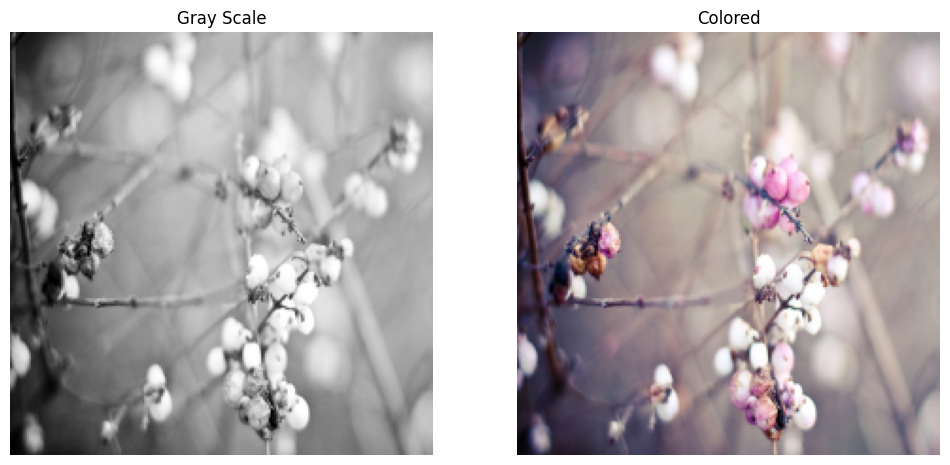

50mmf14 berlin familie flickr lightroom manuelahoffmann 58 bokehlicious


In [9]:
show_input_data(L_data, ab_data, tags_data, 0)

# Создание датасета

In [10]:
class ColorizDataset(Dataset):
    def __init__(self, L_data, ab_data, tags_data,
                 stoi, tag_num=8, transform=None):
        self.L = L_data
        self.ab = ab_data
        self.tag_num = tag_num
        
        self.stoi = stoi
        
        self.transform = transform
        self.tags = self.prepare_tags(tags_data)
    
    
    def prepare_tags(self, tags_data):
        '''
        Для каждой строки, состоящей из тегов берём первые `tag_num` штук
          и переводим с помощью `stoi` в соответствующие им индексы.
        После этого случаи с < 8 кол-вом тегов дополняются 0-ми (соответствует
          символу '' - отсутствие тега)
        '''
        encoded_tags = [torch.tensor( [self.stoi[word] for word in tag_row.split()[:self.tag_num]] )
                            for tag_row in tags_data]
        padded_tags = pad_sequence(encoded_tags, batch_first=True, padding_value=0)
        
        return padded_tags
    
    def __getitem__(self, ind):
        L_ind = self.L[ind]
        L_ind = self.transform(L_ind)

        ab_ind = self.ab[ind]
        ab_ind = self.transform(ab_ind)
        
        tag_ind = self.tags[ind]

        return L_ind, ab_ind, tag_ind

    def __len__(self):
        return len(self.L)


transform = transforms.ToTensor()
dataset = ColorizDataset(L_data, ab_data, tags_data,
                         stoi=words_to_inds, tag_num=tag_num, transform=transform)

In [11]:
train_loader = DataLoader(dataset=dataset, batch_size=batch_size,
                          shuffle=True)
val_loader   = DataLoader(dataset=dataset, batch_size=batch_size,
                          shuffle=True)

In [12]:
## можно проверить вид внешних данных из загрузчика:
#dataiter = iter(train_loader)
#images_gray, images_ab, images_tags = next(dataiter)
#print( images_gray.shape,  images_ab.shape, images_tags.shape)
#print( torch.max(images_gray), torch.min(images_gray), torch.max(images_ab), torch.min(images_ab))
#print(images_tags)
## -> значения L,ab лежат в диапазоне [0, 1]

# Создание класса Нейронной сети

## Вспомогательные функции для генератора

In [13]:
###  для генератора

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        # Identity Mapping
        self.conv_for_ident = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, stride=stride)
        
        self.relu = nn.ReLU(inplace=True)

  
    def forward(self, x):
        identity = x.clone().detach()

        x = self.block(x)
        identity = self.conv_for_ident(identity)

        output = x + identity
        output = self.relu(output)
        return output


## вниз
class UEncoder(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(UEncoder, self).__init__()

        self.down_layer = nn.Sequential(
            nn.MaxPool2d(2, 2),
            ResBlock(in_channels, out_channels, stride=stride)
        )

    def forward(self, x):
        output = self.down_layer(x)
        return output


## вверх
class UDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UDecoder, self).__init__()

        self.upsamp = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.residual_block = ResBlock(in_channels+out_channels, out_channels)      #потому что перед Conv2d происходит конкатенация с identity (skip)
  
    def forward(self, x, skip):
        x = self.upsamp(x)

        x = torch.cat( [x, skip], dim=1)

        output = self.residual_block(x)
        return output


In [14]:
## обработка тегов к виду входных данных
##   (batch_size, tag_num) --> (batch_size, 1, 224, 224)
# отдельным классом, т.к. процесс будет идентичен и в генераторе, и в критике
class Embedding_tags(nn.Module):
    def __init__(self, cond_channels=1,
                 vocab_size=vocab_size, emb_dim=4):
        super(Embedding_tags, self).__init__()
        
        self.lstm_hidden_dim = 32
        self.lstm_num_layers = 2
        
        self.emb = nn.Embedding(vocab_size, emb_dim)
            #(b_s, tag_num) -> (b_s, tag_num, emb_dim)
        self.lstm = nn.LSTM(emb_dim, self.lstm_hidden_dim,
                            num_layers=self.lstm_num_layers, batch_first=True)
            #(b_s, tag_num, emb_dim) -> (b_s, 32)
        self.lin1 = nn.Linear(self.lstm_hidden_dim, 14*14)
            #(b_s, 32) -> (b_s, 14*14)
        self.lin2 = nn.Linear(14*14, 56*56)
            #(b_s, 14*14) -> (b_s, 56*56)
            
        #then in forward reshape to -> (b_s, 1, 56, 56)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=1, bias=False)
            #(b_s, 1, 56, 56) -> (b_s, 32, 56, 56)
        self.bn1 = nn.BatchNorm2d(32)
        #upsample:
            #(b_s, 32, 56, 56) -> (b_s, 32, 112, 112)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1, bias=False)
            #(b_s, 32, 112, 112) -> (b_s, 64, 112, 112)
        self.bn2 = nn.BatchNorm2d(64)
        #upsample again:
            #(b_s, 64, 112, 112) -> (b_s, 64, 224, 224)
        self.conv3 = nn.Conv2d(64, cond_channels, kernel_size=3, padding=1, stride=1, bias=False)
            #(b_s, 64, 224, 224) -> (b_s, 1, 224, 224)
        self.bn3 = nn.BatchNorm2d(cond_channels)
        #желаемая размерность получена
    
    def forward(self, x):
        ## ---- 1d -------------------
        bs, seq_len = x.shape
        x = self.emb(x)

        hidden = torch.zeros((self.lstm_num_layers, bs, self.lstm_hidden_dim)).to(device)
        cell   = torch.zeros((self.lstm_num_layers, bs, self.lstm_hidden_dim)).to(device)
                         # (lstm.num_layers, batch_size, hidden_dim)
        """ собственноручное усложнение своей жизни
        for tag_ind in range(seq_len):
            # x.shape = (b_s, tag_num, emb_dim); => each tag embedding = [:, tag_ind, :]
            # we want to feed to lstm each tag embedding consecutively,
            # но если мы хотим использовать долгую и короткую памяти, необходимо сохранять размерность,
            # поэтому каждый отдельный тег имеет shape = [b_s, 1, emb_dim]
            output, (hidden, cell) = self.lstm(x[:, tag_ind, :].unsqueeze(1), (hidden, cell))
        """
        output, (hidden, cell) = self.lstm(x, (hidden, cell))
        output = output[:, -1, :]  # только результат lstm по Всем тегам
        
        output = self.lin1(output)
        output = self.lin2(output)
        
        ## ---- 2d -------------------
        output = output.view(-1, 1, 56, 56)
        
        output = self.bn1( self.conv1(output) )
        output = self.up(output)
        output = self.bn2( self.conv2(output) )
        #
        output = self.up(output)
        output = self.bn3( self.conv3(output) )
        
        return output

## Сам Генератор

In [15]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, cond_channels,
                 vocab_size, emb_dim=4, dropout_rate=0.5):
        super(Generator, self).__init__()
        
        ## обработка тегов (Conditions)
        self.emb = Embedding_tags(cond_channels, vocab_size, emb_dim)
        
        ## 2 первых слоя конволюции перед началом ResNet'a
        self.enc_layer0 = ResBlock(in_channels+cond_channels, 64)
            #in_channels - изначальные входные данные
            # + cond_channels  - приконкатеннированные условия

        ## спускаемся вниз по U-Net'у
        self.enc_layer1 = UEncoder(64, 128)
        self.enc_layer2 = UEncoder(128, 256)

        ## "центральная" часть (мост)
        self.bridge = UEncoder(256, 512)

        ## возвращаемся к первоначчальным размерам
        self.dec_layer2 = UDecoder(512, 256)
        self.dec_layer1 = UDecoder(256, 128)
        self.dec_layer0 = UDecoder(128, 64)

        ## переводим необходимое нам кол-во каналов в качестве output генератора
        ##   (получили 1 канал: L; на выходе 2 канала: a,b)
        self.output = nn.Conv2d(64, out_channels, kernel_size=1, padding=0)

        # применяется после Conv2d для меньшей зависимости между каналами feature maps
        self.drop = nn.Dropout2d(dropout_rate)

  
    def forward(self, x, conds):
        #форматируем условия до размерности `x`
        conds = self.emb(conds)
        
        #конкатенируем входные данные и условия
        x = torch.cat( [x, conds], dim=1)
        
        # спуск вниз
        e0 = self.enc_layer0(x)   #разные буквы, так как нам нужны skip connections
        e0 = self.drop(e0)   #skip №0
        e1 = self.enc_layer1(e0)
        e1 = self.drop(e1)   #skip №1
        e2 = self.enc_layer2(e1)
        e2 = self.drop(e2)   #skip №2

        # мостик
        b = self.bridge(e2)
        b = self.drop(b)

        # обратно
        d2 = self.dec_layer2(b, e2)
         #d2 = self.drop(d2)    возможно, при увелечении размерности, это не необходимо
        d1 = self.dec_layer1(d2,e1)
         #d1 = self.drop(d1)
        d0 = self.dec_layer0(d1, e0)

        output = self.output(d0)
        return output


In [16]:
check_model = Generator(1,2,1,vocab_size).to(device)
#help(summary)
summary(check_model,
        [(2, 1, 224, 224), (2, 8)],
        batch_dim = None,
        dtypes=[torch.float, torch.int],
        depth=3,
        device=device,
        verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Embedding_tags: 1-1                    [2, 1, 224, 224]          --
|    └─Embedding: 2-1                    [2, 8, 4]                 245,740
|    └─LSTM: 2-2                         [2, 8, 32]                13,312
|    └─Linear: 2-3                       [2, 196]                  6,468
|    └─Linear: 2-4                       [2, 3136]                 617,792
|    └─Conv2d: 2-5                       [2, 32, 56, 56]           288
|    └─BatchNorm2d: 2-6                  [2, 32, 56, 56]           64
|    └─Upsample: 2-7                     [2, 32, 112, 112]         --
|    └─Conv2d: 2-8                       [2, 64, 112, 112]         18,432
|    └─BatchNorm2d: 2-9                  [2, 64, 112, 112]         128
|    └─Upsample: 2-10                    [2, 64, 224, 224]         --
|    └─Conv2d: 2-11                      [2, 1, 224, 224]          576
|    └─BatchNorm2d: 2-12                 [2, 1, 224, 224]    

## Критик (Дискриминатор)

In [17]:
##from torch.nn.modules.instancenorm import InstanceNorm2d
# простенькая cnn: на выходе размерность 1, чем больше число,
#   тем вероятнее, по мнению критика, что картинка настоящая (не сгенерирована)
class Critic(nn.Module):
    def __init__(self, in_channels=3, cond_channels=1,
                 vocab_size=vocab_size, emb_dim=4):
        super(Critic, self).__init__()
        
        # обработка тегов (Conditions)
        self.emb = Embedding_tags(cond_channels, vocab_size, emb_dim)
        
        self.discrim = nn.Sequential(
            # 224x224 - размеры картинки (без feature maps)
            nn.Conv2d(in_channels+cond_channels, 64, kernel_size=4, stride=2, padding=1),   #112x112
                #in_channels - изначальные входные данные (1-L, 2-ab => 3)
                # + 1  - приконкатеннированные условия
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),   #56x56
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  #28x28
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  #14x14
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.AdaptiveAvgPool2d(1), #1x1
            nn.Flatten(),
            nn.Linear(512, 1)  #512 features maps -> 1 скалярный вывод
        )
  
  
    def forward(self, l, ab, conds):
        #форматируем условия до размерности `x`
        conds = self.emb(conds)
        
        x = torch.cat( (l, ab, conds), dim=1)

        output = self.discrim(x)
        return output


In [18]:
check_model = Critic(3,1, vocab_size).to(device)
summary(check_model,
        [(1, 1, 224, 224), (1, 2, 224, 224), (1, 8)],
        batch_dim = None,
        dtypes=[torch.float, torch.float, torch.int],
        depth=3,
        device=device,
        verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Embedding_tags: 1-1                    [1, 1, 224, 224]          --
|    └─Embedding: 2-1                    [1, 8, 4]                 245,740
|    └─LSTM: 2-2                         [1, 8, 32]                13,312
|    └─Linear: 2-3                       [1, 196]                  6,468
|    └─Linear: 2-4                       [1, 3136]                 617,792
|    └─Conv2d: 2-5                       [1, 32, 56, 56]           288
|    └─BatchNorm2d: 2-6                  [1, 32, 56, 56]           64
|    └─Upsample: 2-7                     [1, 32, 112, 112]         --
|    └─Conv2d: 2-8                       [1, 64, 112, 112]         18,432
|    └─BatchNorm2d: 2-9                  [1, 64, 112, 112]         128
|    └─Upsample: 2-10                    [1, 64, 224, 224]         --
|    └─Conv2d: 2-11                      [1, 1, 224, 224]          576
|    └─BatchNorm2d: 2-12                 [1, 1, 224, 224]    

## Воедино

In [19]:
class cWGAN_GP(L.LightningModule):
    def __init__(self, in_channels, out_channels, cond_channels,
                 vocab_size=vocab_size, emb_dim=4,
                 lr=0.0001, n_critic=5, lambda_gp=11, dropout_rate=0.2):
        super(cWGAN_GP, self).__init__()
        
        self.save_hyperparameters()
        self.automatic_optimization = False

        self.generator = Generator(in_channels, out_channels, cond_channels,
                                   vocab_size, emb_dim, dropout_rate=dropout_rate)
        self.critic = Critic(in_channels+out_channels, cond_channels,
                             vocab_size, emb_dim)

        self.lambda_gp = lambda_gp
        self.n_critic = n_critic
        self.apply(self.custom_init_weights)

  
    def custom_init_weights(self, m):
        '''
            нет смысла инициализировать веса большими, учитывая
             что будет применяться gradient penalty
        '''
        if isinstance(m, (nn.Conv2d, nn.BatchNorm2d)):
            #torch.nn.init.normal_(m.weight, 0.0, 0.01)
            m.weight.data.normal_(mean=0.0, std=0.01)
            if m.bias is not None:
                m.bias.data.zero_()


    def configure_optimizers(self):
        learning_rate = self.hparams.lr

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=learning_rate)
        opt_c = torch.optim.Adam(self.critic.parameters(), lr=learning_rate)
        return [opt_g, opt_c], []

    
    def forward(self, z, conds):
        return self.generator(z, conds)
    
    
    
    def gradient_penalty(self, gray, real, fake, conds):
        alpha = torch.rand( (real.shape[0], 1, 1, 1), requires_grad=True ).to(device)
        interpolated_images = real*alpha + fake*(1-alpha)

        #calculate critic scores
        mixed_scores = self.critic(gray, interpolated_images, conds)
        
        
        gradient = torch.autograd.grad(
            inputs=interpolated_images,
            outputs=mixed_scores,
            grad_outputs=torch.ones_like(mixed_scores), #wich size grads would be
            create_graph=True,
            retain_graph=True
        )[0]
        # - computing the gradient of the `mixed_scores` w.r.t. `interpolated_images`

        
        gradient = gradient.view(gradient.shape[0], -1)
        gradient_norm = gradient.norm(2, dim=1) #L2-norm

        gradient_penalty = torch.mean( (gradient_norm - 1)**2 )

        return gradient_penalty
        


    def training_step(self, batch, batch_idx):
        gray, real_ab, conds = batch   #батч имеет вид: (L канал, ab канал, вектор тегов)
        self.current_batch = [gray, real_ab, conds]  
            #сохраним батч, чтобы в конце ипока нарисовать прогресс сети

        optimizer_g, optimizer_c = self.optimizers()

        
        ###  тренеруем Генератор  ###
         #self.toggle_optimizer(optimizer_g)

        fake_ab = self(gray, conds)
        fake_ab = fake_ab.type_as(gray)  #если батч находится на gpu, переместим сгенерированные изображения туда же
        
        fake_score = self.critic(gray, fake_ab, conds)
        g_loss = -torch.mean( fake_score )   #берём среднее от результатов критика по генерирукмым данным со знаком минус,
                                             #   т.к. loss изначально подразумевается к уменьшению, 
                                             #    а правдоподобность картинки пропорциональна выводу критика => надо увеличить

        optimizer_g.zero_grad()   
        self.manual_backward(g_loss)
        optimizer_g.step()

         #self.untoggle_optimizer(optimizer_g)
        ###  конец тренеровки Генератора  ###


        ###  тренеруем Критика  ###
         #self.toggle_optimizer(optimizer_c)

        for repeats in range(self.n_critic):
            #для WGAN рекомендовано, чтобы на 1 тренировочный шаг генератора
            #   приходилось несколько шагов критика (предлагаемое знач. = 5)


            #нужно проверить два условия:
            #   1)входные real_ab помечены, как правдаподобные
            #   2)сгенерированные fake_ab помечены, как неправдаподобные
            #        (но fake_ab должны быть сгенерированы заново, т.к. генератор был немного изменён внутри training_step )
            fake_ab = self(gray, conds).detach()   #но генератор обновляться уже не будет -> .detach()
            fake_ab = fake_ab.type_as(gray)

            real_loss = self.critic(gray, real_ab, conds)
            fake_loss = self.critic(gray, fake_ab, conds)
            gp = self.gradient_penalty(gray, real_ab, fake_ab, conds)

            c_loss = torch.mean(fake_loss) - torch.mean(real_loss) + self.lambda_gp*gp

            optimizer_c.zero_grad()
            self.manual_backward(c_loss)
            optimizer_c.step()

         #self.untoggle_optimizer(optimizer_c)
        ###  конец тренеровки Критика  ###



    def on_train_epoch_end(self):
        #сохраняем промежуточные результаты после каждой эпохи
        torch.save(self.state_dict(), save_path)
        
        ##каждый n-ый epoch выводим
        n = 5
        if ( (self.current_epoch) % n == 0):
            print(f'\nEpoch №{self.current_epoch}')
            self.eval()
            gray, ab, tags = self.current_batch
            compare_result(gray, ab, self(gray, tags), tags)
            self.train()


In [20]:
cwgan_gp = cWGAN_GP(in_channels=1, out_channels=2, cond_channels=1,
            vocab_size=vocab_size, lr=0.0001, lambda_gp=11)
#for name, param in wgan.named_parameters():
#  print(f'{name}: {param}')

# Если надо загрузить

In [21]:
cwgan_gp.load_state_dict(torch.load(save_path))
##cwgan_gp.train()

<All keys matched successfully>

In [22]:
#for name, param in cwgan_gp.named_parameters():
    #if 'emb' in name:
        #param.requires_grad_(False)
        #s += param.numel()
    #print(name, '|', param.requires_grad)

# Тренируем

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | generator | Generator | 9.1 M  | train
1 | critic    | Critic    | 3.7 M  | train
------------------------------------------------
12.8 M    Trainable params
0         Non-trainable params
12.8 M    Total params
51.122    Total estimated model params size (MB)
128       Modules in train mode
0         Modules in eval mode



Epoch №0
00%|█████████████████████████████████████████████████████████████| 834/834 [31:19<00:00,  0.44it/s, v_num=13]

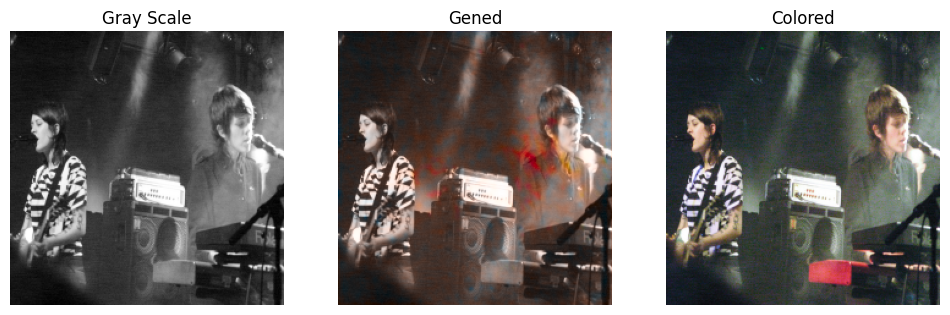

tegan sara live concert cardiff con jealous 

Epoch №5
00%|█████████████████████████████████████████████████████████████| 834/834 [29:01<00:00,  0.48it/s, v_num=13]

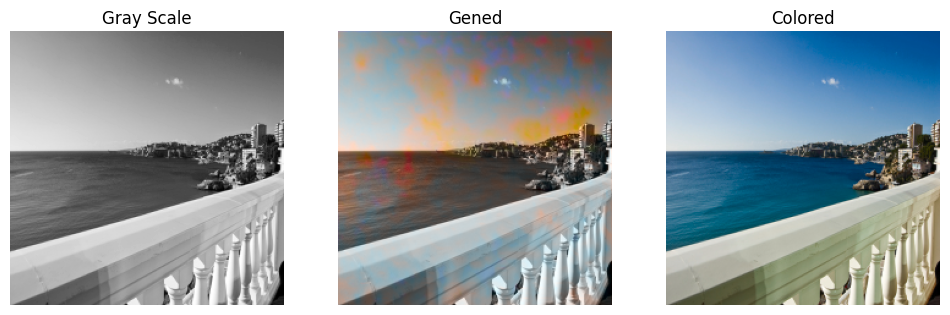

calamajor blue sea palma mallorca majorca palmademallorca hotelnixepalace

Epoch №10
00%|████████████████████████████████████████████████████████████| 834/834 [29:05<00:00,  0.48it/s, v_num=13]

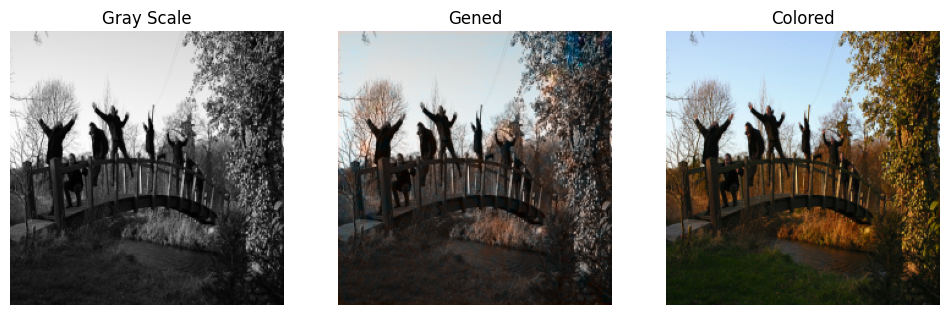

longjump jump bridge winterafternoon sunshine celebration vob olympics


`Trainer.fit` stopped: `max_epochs=11` reached.



poch 10: 100%|████████████████████████████████████████████████████████████| 834/834 [29:06<00:00,  0.48it/s, v_num=13]

In [28]:
#epoch_num
trainer = L.Trainer(max_epochs=11, accelerator="auto")
trainer.fit(cwgan_gp, train_loader)

# Сохранение промежуточных результатов

In [30]:
# до: ~280 эпох
# после нового лстм:
#  виесте:   55_0 + 
#  отдельно: 16

torch.save(cwgan_gp.state_dict(), save_path)
#на всякий случай?
torch.save(cwgan_gp.generator.state_dict(), data_folder + 'saves/generator.pth')
torch.save(cwgan_gp.critic.state_dict(),    data_folder + 'saves/critic.pth')

In [36]:
import gc
gc.collect()

25271

# Валидация

In [23]:
cwgan_gp.eval()
val_iter = iter(val_loader)

In [24]:
cwgan_gp.training, cwgan_gp.device

(False, device(type='cpu'))

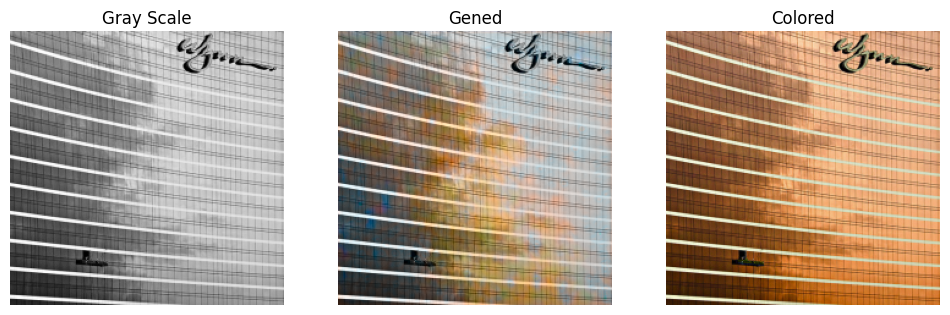

macao wynn cleaningglass building architecture nikon d300 sigma


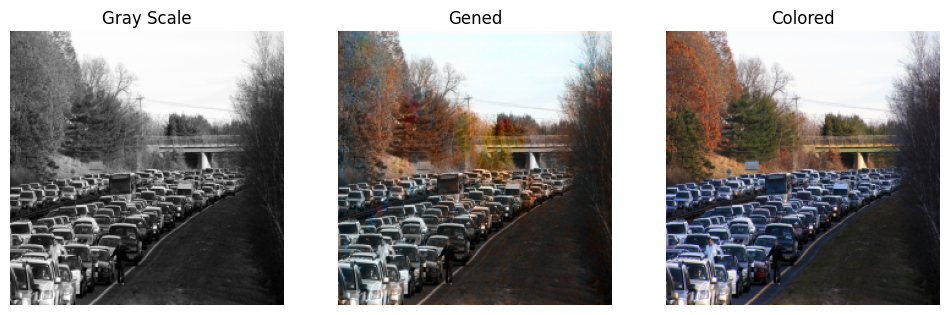

gsp parkway gardenstateparkway accident mp120 cheesequake police trafficjam


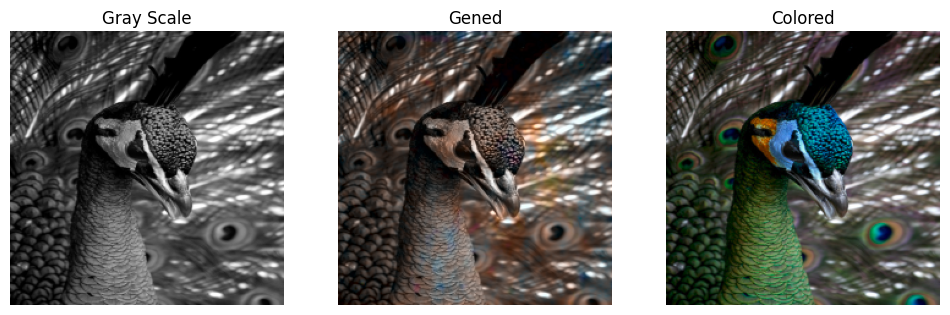

london zoo animals zoology bird peacock peahen green


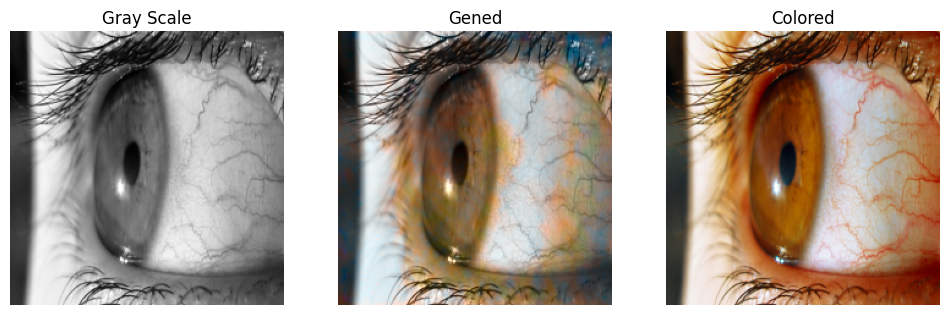

macro retina muriel etringita ojo iris pupila playa


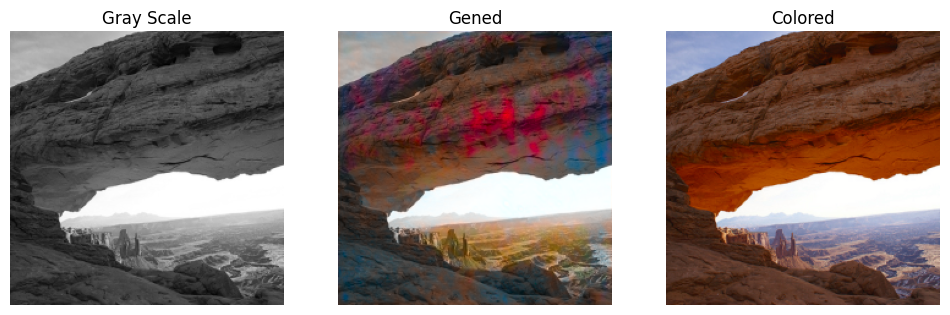

canyonlands       


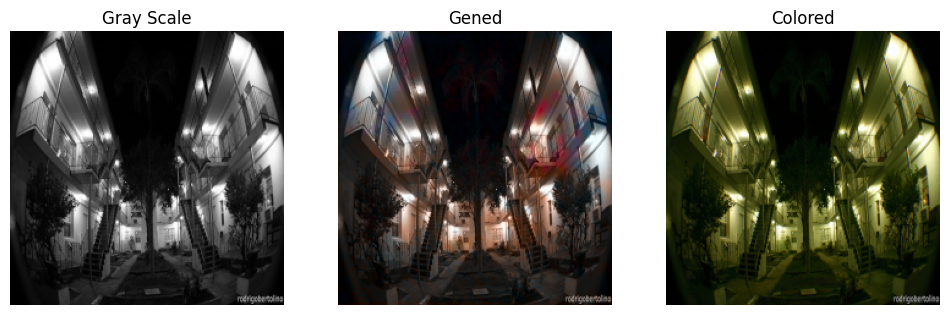

In [25]:
gray, real, tags = next(val_iter)
cwgan_gp.to(device)
with torch.no_grad():
    generated = cwgan_gp(gray.to(device), tags.to(device))
    for i in range(batch_size):
        compare_result(gray, real, generated, tags, i)

In [26]:
generated.min(), generated.max()

(tensor(0.3564, device='cuda:0'), tensor(0.9732, device='cuda:0'))

# Доп проверка и пр.

In [24]:
#vocab_size
cwgan_gp.state_dict()['generator.emb.emb.weight'].shape, vocab_size

(torch.Size([61435, 4]), 61435)

In [54]:
## test load
test_model = cWGAN_GP(in_channels=1, out_channels=2, cond_channels=1,
            vocab_size=vocab_size, lr=1, lambda_gp=1)

In [56]:
test_model.lambda_gp

1

In [63]:
#test_model.state_dict()
test_model.generator.emb.emb.weight

Parameter containing:
tensor([[-1.2908e+00,  9.1776e-01, -5.0497e-01, -1.6397e+00],
        [-1.9683e-01, -3.0291e-01,  1.0768e+00,  2.1640e+00],
        [ 1.1333e+00,  6.2831e-01,  1.1930e+00, -6.0922e-04],
        ...,
        [-5.1839e-01,  5.1993e-01,  9.5302e-01,  9.0438e-01],
        [-1.3067e+00, -7.1151e-01, -2.4329e-01, -3.3893e-01],
        [-1.8915e+00,  6.2543e-01, -5.2196e-01, -1.3668e+00]],
       requires_grad=True)

In [73]:
test_model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [74]:
test_model.lambda_gp, cwgan_gp.lambda_gp

(1, 11)

In [75]:
test_model.generator.emb.emb.weight

Parameter containing:
tensor([[-1.7646,  1.1509, -0.6890, -0.8544],
        [ 0.8184,  0.5522,  1.5118, -0.3288],
        [-0.2154, -0.5827, -0.6541, -1.4855],
        ...,
        [-2.3984, -0.6817,  0.6498, -0.8239],
        [-0.1162, -1.2541,  0.7434,  0.2970],
        [-1.7300,  1.9103,  0.2025,  0.4550]], requires_grad=True)

In [82]:
(test_model.generator.emb.emb.weight == cwgan_gp.generator.emb.emb.weight).prod()

tensor(1)

In [85]:
#test_model.state_dict()

In [79]:
seq_len = 8  # не мешает работе
rnn = nn.LSTM(input_size=4, hidden_size=2, num_layers=1, batch_first=True)
inp = torch.randn(2, seq_len, 4)

hidden = torch.randn(1, 2, 2)
cell   = torch.randn(1, 2, 2)
hidden2 = hidden.clone()
cell2 = cell.clone()

output, (hidden, cell) = rnn(inp, (hidden, cell))
display(output[:, -1, :], output.shape)
for tag_ind in range(seq_len):
    # x.shape = (b_s, tag_num, emb_dim); => each tag embedding = [:, tag_ind, :]
    # we want to feed to lstm each tag embedding consecutively,
    # но если мы хотим использовать долгую и короткую памяти, необходимо сохранять размерность,
    # поэтому каждый отдельный тег имеет shape = [b_s, 1, emb_dim]
    output, (hidden2, cell2) = rnn(inp[:, tag_ind, :].unsqueeze(1), (hidden2, cell2))
output[:, -1, :], output.shape

tensor([[ 0.1296, -0.0561],
        [-0.0391, -0.0963]], grad_fn=<SliceBackward0>)

torch.Size([2, 8, 2])

(tensor([[ 0.1296, -0.0561],
         [-0.0391, -0.0963]], grad_fn=<SliceBackward0>),
 torch.Size([2, 1, 2]))